In [1]:
import numpy as np
import os
# plotting figure
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
# Using similar values as in online handbook
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)


In [2]:
# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

/home/sfefilatyev/projects/tensorflow_exercises/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sfefilatyev/projects/tensorflow_exercises/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sfefilatyev/projects/tensorflow_exercises/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int1

In [3]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  # wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)


In [4]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [5]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

In [6]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Saving figure time_series_plot


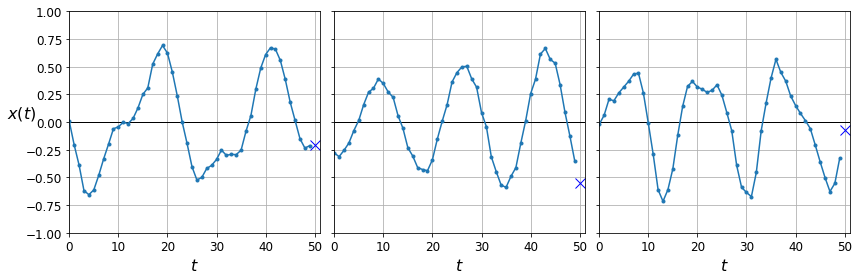

In [7]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()

In [8]:
# Baseline metrics
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020769933

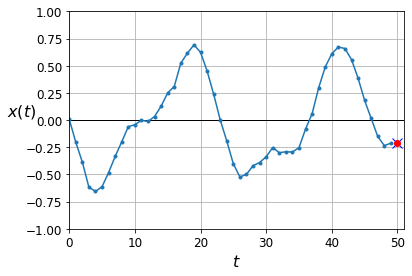

In [11]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [12]:
# Implementing simple linear regression (through a fully connected network)
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 0s 37us/sample - loss: 0.1025 - val_loss: 0.0550
Epoch 2/20
7000/7000 [==============================] - 0s 27us/sample - loss: 0.0397 - val_loss: 0.0275
Epoch 3/20
7000/7000 [==============================] - 0s 25us/sample - loss: 0.0213 - val_loss: 0.0162
Epoch 4/20
7000/7000 [==============================] - 0s 27us/sample - loss: 0.0136 - val_loss: 0.0116
Epoch 5/20
7000/7000 [==============================] - 0s 27us/sample - loss: 0.0104 - val_loss: 0.0096
Epoch 6/20
7000/7000 [==============================] - 0s 24us/sample - loss: 0.0089 - val_loss: 0.0085
Epoch 7/20
7000/7000 [==============================] - 0s 24us/sample - loss: 0.0079 - val_loss: 0.0077
Epoch 8/20
7000/7000 [==============================] - 0s 25us/sample - loss: 0.0072 - val_loss: 0.0070
Epoch 9/20
7000/7000 [==============================] - 0s 25us/sample - loss: 0.0066 - val_loss: 0.0065
Epoch 1

In [13]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 18us/sample - loss: 0.0041


0.004148767173290253

In [14]:
# Add code for plotting learning curves

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

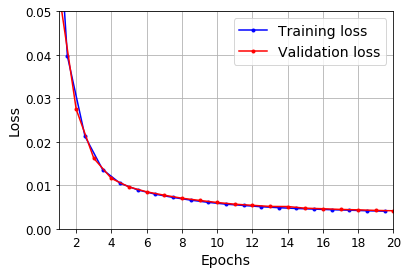

In [15]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

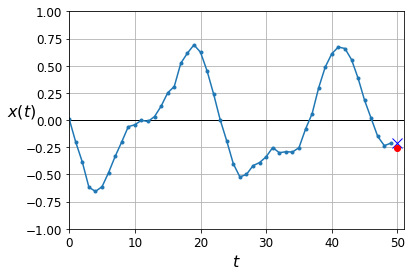

In [16]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [17]:
# Implementing a simple RNN

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([keras.layers.SimpleRNN(1, input_shape=[None, 1])])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 2s 271us/sample - loss: 0.0960 - val_loss: 0.0469
Epoch 2/20
7000/7000 [==============================] - 1s 202us/sample - loss: 0.0362 - val_loss: 0.0291
Epoch 3/20
7000/7000 [==============================] - 1s 201us/sample - loss: 0.0247 - val_loss: 0.0218
Epoch 4/20
7000/7000 [==============================] - 1s 200us/sample - loss: 0.0193 - val_loss: 0.0178
Epoch 5/20
7000/7000 [==============================] - 1s 199us/sample - loss: 0.0162 - val_loss: 0.0153
Epoch 6/20
7000/7000 [==============================] - 1s 195us/sample - loss: 0.0143 - val_loss: 0.0138
Epoch 7/20
7000/7000 [==============================] - 1s 201us/sample - loss: 0.0130 - val_loss: 0.0128
Epoch 8/20
7000/7000 [==============================] - 1s 197us/sample - loss: 0.0122 - val_loss: 0.0122
Epoch 9/20
7000/7000 [==============================] - 1s 198us/sample - loss: 0.0118 - val_loss: 0.011

In [17]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 0s 101us/sample - loss: 0.0115


0.011530071020126343

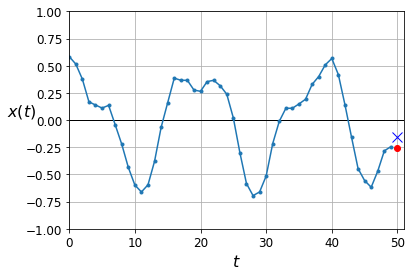

In [18]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [18]:
# Implementing a Deep-RNN

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 6s 848us/sample - loss: 0.0535 - val_loss: 0.0098
Epoch 2/20
7000/7000 [==============================] - 5s 689us/sample - loss: 0.0068 - val_loss: 0.0059
Epoch 3/20
7000/7000 [==============================] - 5s 694us/sample - loss: 0.0051 - val_loss: 0.0047
Epoch 4/20
7000/7000 [==============================] - 5s 757us/sample - loss: 0.0043 - val_loss: 0.0041
Epoch 5/20
7000/7000 [==============================] - 5s 681us/sample - loss: 0.0039 - val_loss: 0.0038
Epoch 6/20
7000/7000 [==============================] - 5s 748us/sample - loss: 0.0038 - val_loss: 0.0040
Epoch 7/20
7000/7000 [==============================] - 5s 727us/sample - loss: 0.0037 - val_loss: 0.0035
Epoch 8/20
7000/7000 [==============================] - 5s 687us/sample - loss: 0.0035 - val_loss: 0.0035
Epoch 9/20
7000/7000 [==============================] - 5s 677us/sample - loss: 0.0034 - val_loss: 0.003

In [19]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 1s 330us/sample - loss: 0.0030


0.002970228862017393

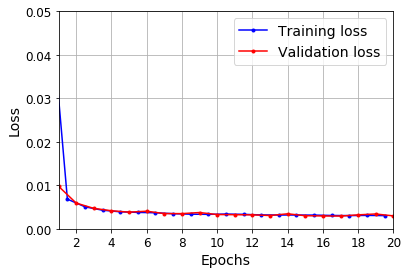

In [20]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

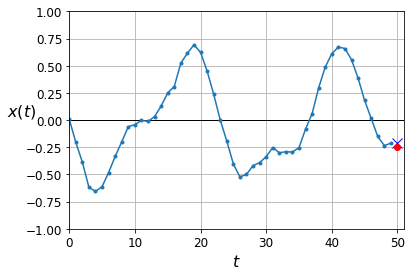

In [21]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()